## **DS-226 Course Project**

* Tsungrojungla Walling : tsungrojungl@iisc.ac.in
* Barnopriyo Dutta : barnopriyod@iisc.ac.in
* Debojjal Bagchi (16849) : debojjalb@iisc.ac.in


### Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import sklearn
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble  import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

### Load Dataset

In [2]:
df = pd.read_excel('https://github.com/debojjalb/grade_pred/blob/main/Maths.xlsx?raw=true')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
df.shape

(397, 33)

In [4]:
df[df.isnull().any(axis=1)]
df.shape

(397, 33)

In [5]:
print(len(df.columns))
df.columns


33


Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [6]:
'''
for cols in df.columns:
  fig = sns.displot(df, x=cols)
  fig.savefig('plot'+str(cols)+'.png')
'''

"\nfor cols in df.columns:\n  fig = sns.displot(df, x=cols)\n  fig.savefig('plot'+str(cols)+'.png')\n"

In [7]:
'''
for cols in df.columns:
  print(df[cols].value_counts())
  print("\n")
'''

'\nfor cols in df.columns:\n  print(df[cols].value_counts())\n  print("\n")\n'

In [8]:
#Create a markup kaggle with what each of the features mean

### Data Engineering

In [9]:
#Average out G1, G2, G3 Columns into a column called grade, delete columns G1, G2, G3.
#Drop school name columns
#Handle rows with na, Use dropna or fill with 0 based on which feature
#Do feature engineering, use your creativity here, For example you can create a 
#feature called study ratio = study time/ travel time. or recreation = free time / travel time
#Think of features that are more related from grades and can be derived from
#given features. If you think after creating new featires old features arent requried
#delete them. (In the study ratio example old features seem imp too!)
# Use ratios, division by mean, etc for feature engg
# You can also use 'groupby' for example for urban people, take travel time and divide by avg
# travel time and same for rural. 
# df.groupby('address')['traveltime'].mean()

X_train = df.drop(['school'], axis =1)

X_train['grade']=(df['G1'] + df['G2'] +df['G3'])/3.0
X_train.drop(['G1','G2','G3'], axis=1)
X_train['Relative study time']= df['studytime']/df['traveltime']
X_train['Relative free time']= df['freetime']/df['traveltime']
X_train['Relative absences']= df['absences']/df['studytime']


In [10]:
print(X_train.groupby('address')['traveltime'].mean())
X_train['traveltime'].mean()

address
R    1.876404
U    1.327922
Name: traveltime, dtype: float64


1.45088161209068

In [11]:
mean_R= 1.876404
mean_U= 1.327922
mean_overall= 1.45088161

In [12]:
X_train.loc[X_train['address'] == 'R','normtraveltime'] = X_train['traveltime']/mean_R
X_train.loc[X_train['address'] == 'U', 'normtraveltime'] = X_train['traveltime']/mean_U
X_train['normtraveltimewhole']= X_train['traveltime']/mean_overall

In [13]:
X_train.drop(['G1','G2','G3'], axis=1, inplace=True)

Text(0, 0.5, 'Counts')

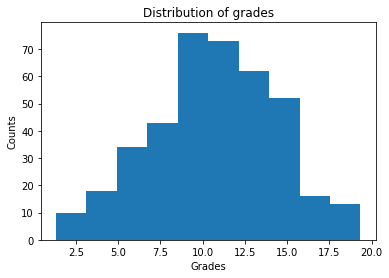

In [14]:
plt.hist(X_train['grade'])
plt.title('Distribution of grades')
plt.xlabel('Grades')
plt.ylabel('Counts')

In [15]:
#Use Lasso for feature selection. Choose the features with non zero alpha
#Use: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
# Or use: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV
# With 10 fold cross validation
#Play around with alpha for finding good number of features to carry forward
#Delete dataframe of features with low to 0 weights
#Around 10-15 features seems good (yor call after seeing coeff values)

Y_train=X_train['grade']
X_train.drop(['grade'], axis=1, inplace=True)
X_train = pd.get_dummies(X_train, columns = ['schoolsup', 'sex','address' ,'famsize','Pstatus', 'Mjob', 'Fjob','reason','guardian','famsup','paid','activities','nursery','higher','internet','romantic'])
X_train.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,3,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0


### LASSO for feature selection 

In [16]:
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_train, Y_train, test_size=0.3, random_state=10)
list_numerical = []

In [17]:
for cols in X_train.columns:
  if cols not in ['schoolsup', 'sex','address' ,'famsize','Pstatus', 'Mjob', 'Fjob','reason','guardian','famsup','paid','activities','nursery','higher','internet','romantic']:
    list_numerical.append(cols)

print(len(X_train.columns))
print(len(list_numerical))

59
59


In [18]:
model= sklearn.linear_model.LassoCV( eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize='deprecated', precompute='auto', max_iter=1000, tol=0.0001, copy_X=True, cv=10, verbose=False, n_jobs=None, positive=False, random_state=None, selection='cyclic')
scaler = StandardScaler().fit(X_train_lasso[list_numerical]) 
X_train_lasso[list_numerical] = scaler.transform(X_train_lasso[list_numerical])
X_test_lasso[list_numerical] = scaler.transform(X_test_lasso[list_numerical])
clf=model.fit(X_train_lasso, y_train_lasso)
print(model.alpha_)


0.17552820323250823


In [19]:
print('R squared training set', round(model.score(X_train_lasso, y_train_lasso)*100, 2))
print('R squared test set', round(model.score(X_test_lasso, y_test_lasso)*100, 2))

R squared training set 30.36
R squared test set 13.8


In [20]:
clf.coef_

array([-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.26851584e-01,
        0.00000000e+00, -1.24759518e+00, -0.00000000e+00,  0.00000000e+00,
       -4.78006044e-01,  0.00000000e+00,  0.00000000e+00, -1.65967086e-01,
        0.00000000e+00,  1.03977482e-01,  1.57837094e-01,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  3.07244217e-01, -9.23449043e-16,
       -2.64604647e-01,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  1.01654192e-01, -2.16592156e-01,  3.24705770e-01,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -6.25056385e-02,
       -0.00000000e+00,  1.58854503e-01, -6.95193166e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  1.84061877e-01, -1.02605449e-16, -4.46908555e-03,
        7.69540869e-17, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -

In [21]:
len(clf.coef_)

59

In [22]:
len(clf.feature_names_in_)

59

In [23]:
clf.feature_names_in_

array(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences', 'Relative study time', 'Relative free time',
       'Relative absences', 'normtraveltime', 'normtraveltimewhole',
       'schoolsup_no', 'schoolsup_yes', 'sex_F', 'sex_M', 'address_R',
       'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A',
       'Pstatus_T', 'Mjob_at_home', 'Mjob_health', 'Mjob_other',
       'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health',
       'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course',
       'reason_home', 'reason_other', 'reason_reputation',
       'guardian_father', 'guardian_mother', 'guardian_other',
       'famsup_no', 'famsup_yes', 'paid_no', 'paid_yes', 'activities_no',
       'activities_yes', 'nursery_no', 'nursery_yes', 'higher_no',
       'higher_yes', 'internet_no', 'internet_yes', 'romantic_no',
       'romantic_yes'], dtype=object)

In [24]:
selected_features = []
for index, value in enumerate(clf.coef_):
  if value != 0:
    selected_features.append(clf.feature_names_in_[index])
selected_features = list(selected_features)
len(selected_features)

24

In [25]:
print(selected_features)

['traveltime', 'failures', 'goout', 'health', 'Relative study time', 'Relative free time', 'schoolsup_no', 'schoolsup_yes', 'sex_F', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Fjob_other', 'Fjob_teacher', 'reason_course', 'famsup_no', 'famsup_yes', 'paid_no', 'paid_yes', 'higher_no', 'higher_yes', 'internet_no', 'romantic_no', 'romantic_yes']


In [26]:
print("LASSO features with 0 Coeff")
for data in clf.feature_names_in_:
  if data not in selected_features:
    print(data)

LASSO features with 0 Coeff
age
Medu
Fedu
studytime
famrel
freetime
Dalc
Walc
absences
Relative absences
normtraveltime
normtraveltimewhole
sex_M
address_R
address_U
famsize_GT3
famsize_LE3
Pstatus_A
Pstatus_T
Mjob_at_home
Mjob_teacher
Fjob_at_home
Fjob_health
Fjob_services
reason_home
reason_other
reason_reputation
guardian_father
guardian_mother
guardian_other
activities_no
activities_yes
nursery_no
nursery_yes
internet_yes


In [27]:
X_train = X_train[selected_features]
X_train.head()

,traveltime,failures,goout,health,Relative study time,Relative free time,schoolsup_no,schoolsup_yes,sex_F,Mjob_health,...,reason_course,famsup_no,famsup_yes,paid_no,paid_yes,higher_no,higher_yes,internet_no,romantic_no,romantic_yes
0,2,0,4,3,1.0,1.5,0,1,1,0,...,1,1,0,1,0,0,1,1,1,0
1,1,0,3,3,2.0,3.0,1,0,1,0,...,1,0,1,1,0,0,1,0,1,0
2,1,3,2,3,2.0,3.0,0,1,1,0,...,0,1,0,0,1,0,1,0,1,0
3,1,0,2,5,3.0,2.0,1,0,1,1,...,0,0,1,0,1,0,1,0,0,1
4,1,0,2,5,2.0,3.0,1,0,1,0,...,0,0,1,0,1,0,1,1,1,0


### Drop highly correlated columns

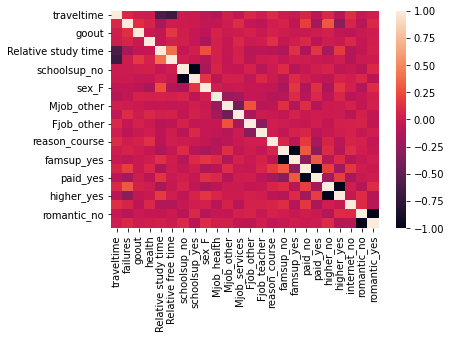

In [28]:
X_train.corr()
corrMatrix = X_train.corr()
sns.heatmap(corrMatrix)
plt.show()

In [29]:
#Drop highly correlated columns

# Create correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)

# Drop features 
X_train.drop(to_drop, axis=1, inplace=True)

['schoolsup_yes', 'famsup_yes', 'paid_yes', 'higher_yes', 'romantic_yes']


<ipython-input-29-7d3244911bcd>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


### Bin scores into grades (3,2,1 for high, medium, low)

In [30]:
X_train.head()

,traveltime,failures,goout,health,Relative study time,Relative free time,schoolsup_no,sex_F,Mjob_health,Mjob_other,Mjob_services,Fjob_other,Fjob_teacher,reason_course,famsup_no,paid_no,higher_no,internet_no,romantic_no
0,2,0,4,3,1.0,1.5,0,1,0,0,0,0,1,1,1,1,0,1,1
1,1,0,3,3,2.0,3.0,1,1,0,0,0,1,0,1,0,1,0,0,1
2,1,3,2,3,2.0,3.0,0,1,0,0,0,1,0,0,1,0,0,0,1
3,1,0,2,5,3.0,2.0,1,1,1,0,0,0,0,0,0,0,0,0,0
4,1,0,2,5,2.0,3.0,1,1,0,1,0,1,0,0,0,0,0,1,1


In [31]:
Y_train

0       5.666667
1       5.333333
2       8.333333
3      14.666667
4       8.666667
         ...    
392     8.333333
393    11.000000
394     8.666667
395     5.666667
396     3.666667
Name: grade, Length: 397, dtype: float64

In [32]:
bins = np.linspace(start=min(Y_train)-0.1, stop=max(Y_train)+0.1, num=4)

In [33]:
np.isnan(Y_train).any()

False

In [34]:
Y_train.shape

(397,)

In [35]:
Y_train_scores = Y_train

In [36]:
Y_train_pp = pd.cut(Y_train, bins)
Y_train_pp.value_counts()

(7.3, 13.367]       234
(13.367, 19.433]     93
(1.233, 7.3]         70
Name: grade, dtype: int64

In [37]:
Y_train_pp.unique()

[(1.233, 7.3], (7.3, 13.367], (13.367, 19.433]]
Categories (3, interval[float64, right]): [(1.233, 7.3] < (7.3, 13.367] < (13.367, 19.433]]

In [38]:
Y_train  = np.zeros(397)
for index, value in enumerate(Y_train_pp):
  if value == Y_train_pp.unique()[0]:
    Y_train[index] = 1
  if value == Y_train_pp.unique()[1]:
    Y_train[index] = 2
  if value == Y_train_pp.unique()[2]:
    Y_train[index] = 3

In [39]:
print(Y_train_scores)

0       5.666667
1       5.333333
2       8.333333
3      14.666667
4       8.666667
         ...    
392     8.333333
393    11.000000
394     8.666667
395     5.666667
396     3.666667
Name: grade, Length: 397, dtype: float64


In [40]:
np.unique(Y_train, return_counts=True)

(array([1., 2., 3.]), array([ 70, 234,  93]))

Text(0, 0.5, 'Counts')

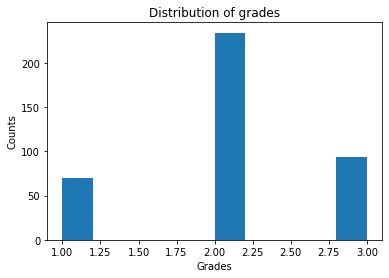

In [41]:
plt.hist(Y_train)
plt.title('Distribution of grades')
plt.xlabel('Grades')
plt.ylabel('Counts')

### Test train split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [43]:
#Declare feature and target vector
#Split test train data, 8:2
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(317, 19)
(317,)
(80, 19)
(80,)


### Random forest classifier

In [44]:
clf = RandomForestClassifier()

# fit the model
clf.fit(X_train, y_train)


RandomForestClassifier()

In [45]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

y_pred = clf.predict(X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred_train = clf.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))



Training set score: 0.9968
Test set score: 0.5375
Model accuracy score: 0.5375
Training-set accuracy score: 0.9968


In [46]:
'''
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
n_estimators = [100,200,400,800,1000]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for val in n_estimators:
    score = cross_val_score(RandomForestClassifier(n_estimators= val, random_state= 42), X_train, y_train, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
max_depth = [5,15,25,35]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for val in max_depth:
    score = cross_val_score(RandomForestClassifier(n_estimators = 400, max_depth= val, random_state= 42), X_train, y_train, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
n_features = [5,10,15,23]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for val in n_features:
    score = cross_val_score(RandomForestClassifier(n_estimators = 400, max_depth = 25, max_features= val, random_state= 42), X_train, y_train, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

'''


'\nfrom sklearn.model_selection import KFold, StratifiedKFold, cross_val_score\nn_estimators = [100,200,400,800,1000]\nkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\nfor val in n_estimators:\n    score = cross_val_score(RandomForestClassifier(n_estimators= val, random_state= 42), X_train, y_train, cv= kf, scoring="accuracy")\n    print(f\'Average score({val}): {"{:.3f}".format(score.mean())}\')\n\nfrom sklearn.model_selection import KFold, StratifiedKFold, cross_val_score\nmax_depth = [5,15,25,35]\nkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\nfor val in max_depth:\n    score = cross_val_score(RandomForestClassifier(n_estimators = 400, max_depth= val, random_state= 42), X_train, y_train, cv= kf, scoring="accuracy")\n    print(f\'Average score({val}): {"{:.3f}".format(score.mean())}\')\n\nfrom sklearn.model_selection import KFold, StratifiedKFold, cross_val_score\nn_features = [5,10,15,23]\nkf = StratifiedKFold(n_splits=5, shuffle=True, random_st

### Grid search cross validation

In [47]:
rfc = RandomForestClassifier()
forest_params = [{'max_depth':[5,10,20,30], 'max_features':[10,15,18] , 'n_estimators' : [100,200,400,800]}]
clf = GridSearchCV(rfc, forest_params, cv = 10, scoring='accuracy', verbose=1)
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
{'max_depth': 5, 'max_features': 10, 'n_estimators': 100}
0.6214717741935484


### Results

In [48]:
print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

y_pred = clf.predict(X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred_train = clf.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Test set score: 0.6000
Training set score: 0.7476
Model accuracy score: 0.6000
Training-set accuracy score: 0.7476


In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.50      0.14      0.22        14
         2.0       0.61      0.89      0.73        46
         3.0       0.56      0.25      0.34        20

    accuracy                           0.60        80
   macro avg       0.56      0.43      0.43        80
weighted avg       0.58      0.60      0.54        80

